In [1]:
%load_ext watermark
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from myst_nb import glue
import statsmodels.api as sm
from scipy import stats

from plastockmethods import name_the_zones, name_the_particles, frequentation_name, situation_name
from plastockmethods import particle_groups, name_the_substrate, name_the_distance, table_css_styles

def translate_describe(x, value_column):
    described = x.to_dict()
    described.pop("count")
    described["moyenne"] = described.pop("mean")
    described["écart-type"] = described.pop("std")
    df = pd.DataFrame(described.items())
    df.set_index(0, inplace=True)
    df.rename(columns={1:value_column}, inplace=True)
    df.index.name = None
    
    
    return df

work_data = pd.read_csv("data/end_pipe/long_form_micro.csv")
wide_form = pd.read_csv("data/end_pipe/aggregated_micro_results.csv")
beach_data = pd.read_csv("data/end_pipe/asl_beaches.csv")

wdx = work_data.copy()
wdx["position"] = wdx.position.apply(lambda x: name_the_zones[x])
wdx["frequentation"] = wdx.frequentation.apply(lambda x: frequentation_name[x])
wdx["situation"] = wdx.situation.apply(lambda x: situation_name[x])
wdx["distance"] = wdx.distance.apply(lambda x: name_the_distance[x])
wdx["substrat"] = wdx.substrat.apply(lambda x: name_the_substrate[x])

# Regression

La position des échantillons sur la plage (ligne d'eau, plage-seche) représente différentes conditions d'échantillonnage. C'est pourquoi nous les traiterons séparément.

Les fragments durs et souple sont combinés pour chaque échantillon.

## Ligne d'eau

In [2]:
caption = "Les données sont regroupées en deux groupes par échantillon: 1. fibres, 2. fragment."

# separate the first zone
wdi = wdx[wdx.position == "ligne-d'eau"].copy()
scaled = (wdi["compte"] - wdi["compte"].min()) / (wdi["compte"].max() - wdi["compte"].min())
wdi["compte"] = scaled

# wdi["const"] = 1.0

# columns of interest
x_cols = ["orientation", "substrat", "frequentation", "situation", "distance", "objet"]
y_col = ["compte"]

# combine the fragments
w_f = wdi[wdi.objet.isin(["souple", "fdure"])].copy()

souple_d = w_f.groupby(["echantillon", *x_cols[:-1]], as_index=False).compte.sum()
souple_d["objet"] = "fragment"

# isolate the fibres
fibres = wdi[wdi.objet.isin(["fibres"])].copy()

# combine the aggregate fragments and the fibres
w_d = pd.concat([souple_d[[*x_cols, *y_col]], fibres[[*x_cols, *y_col]]])


w_d.head().style.set_table_styles(table_css_styles).set_caption(caption)

,orientation,substrat,frequentation,situation,distance,objet,compte
0,NE,galet,élévée,campagne,< 100m,fragment,0.000000
1,NNE,galet,élévée,campagne,< 100m,fragment,0.024834
2,NE,galet,élévée,campagne,< 100m,fragment,0.000000
3,NNE,galet,élévée,campagne,< 100m,fragment,0.004967
4,NNO,galet,moyenne,campagne,< 100m,fragment,0.014901


### Régression des moindres carrés ordinaires (MCO)

__Toutes les variables__

In [3]:
# make dumby variables
x_dum = pd.get_dummies(w_d[x_cols], drop_first=True)

Y = w_d["compte"]

an_ols = sm.OLS(Y, x_dum)
ols_fit = an_ols.fit()
ols_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 compte   R-squared (uncentered):                   0.553
Model:                            OLS   Adj. R-squared (uncentered):              0.496
Method:                 Least Squares   F-statistic:                              9.735
Date:                Wed, 11 Oct 2023   Prob (F-statistic):                    5.78e-23
Time:                        08:00:09   Log-Likelihood:                          178.31
No. Observations:                 222   AIC:                                     -306.6
Df Residuals:                     197   BIC:                                     -221.6
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
orientation_ENE              0.2757      0.082      3.358      0.001       0.114       0.438
orientation_ESE              0.1694      0.113      1.502      0.135      -0.053       0.392
orientation_N                0.1039      0.065      1.587      0.114      -0.025       0.233
orientation_NE               0.1219      0.084      1.456      0.147      -0.043       0.287
orientation_NNE              0.1372      0.074      1.853      0.065      -0.009       0.283
orientation_NNO              0.0742      0.063      1.179      0.240      -0.050       0.198
orientation_NO               0.1901      0.064      2.982      0.003       0.064       0.316
orientation_O                0.1180      0.089      1.319      0.189      -0.058       0.294
orientation_ONO              0.1019      0.093      1.094      0.275      -0.082       0.286
orientation_OSO              0.1409      0.085      1.654      0.100      -0.027       0.309
orientation_S                0.1113      0.078      1.422      0.157      -0.043       0.266
orientation_SE               0.1689      0.061      2.750      0.007       0.048       0.290
orientation_SO               0.1907      0.075      2.534      0.012       0.042       0.339
orientation_SSE              0.0864      0.076      1.133      0.259      -0.064       0.237
orientation_SSO              0.1188      0.076      1.567      0.119      -0.031       0.268
substrat_gravier            -0.0048      0.046     -0.103      0.918      -0.096       0.086
substrat_sable fin           0.0619      0.026      2.381      0.018       0.011       0.113
substrat_sable grosssier    -0.0312      0.043     -0.731      0.466      -0.116       0.053
frequentation_moyenne        0.0623      0.051      1.210      0.228      -0.039       0.164
frequentation_élévée        -0.0359      0.069     -0.522      0.602      -0.172       0.100
situation_urbain            -0.0089      0.034     -0.262      0.794      -0.076       0.058
distance_500 - 1000m         0.0185      0.108      0.172      0.864      -0.194       0.231
distance_< 100m              0.0081      0.025      0.330      0.742      -0.040       0.057
distance_> 1000m            -0.0858      0.063     -1.359      0.176      -0.210       0.039
objet_fragment              -0.0930      0.015     -6.030      0.000      -0.123      -0.063
==============================================================================
Omnibus:                      234.304   Durbin-Watson:                   1.736
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8583.985
Skew:                           4.162   Prob(JB):                         0.00
Kurtosis:                      32.304   Cond. No.               

__Residuals__

Dans la régression linéaire, un _residual_ est la différence entre la valeur réelle et la valeur prédite par le modèle (y-ŷ) pour un point donné. Un modèle de régression des moindres carrés minimise la somme des carrés des résidus

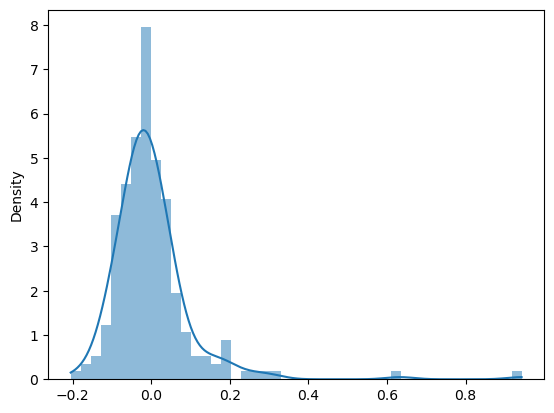

In [4]:
fig, ax = plt.subplots()
sns.histplot(x=ols_fit.resid, ax=ax, stat="density", linewidth=0, kde=True)
plt.show()

#### QQ plot

Un graphique q-q est un graphique des quantiles du premier ensemble de données par rapport aux quantiles du second ensemble de données. Par quantile, nous entendons la fraction (ou le pourcentage) de points inférieurs à la valeur donnée. Ainsi, le quantile 0,3 (ou 30 %) est le point auquel 30 % des données sont inférieures et 70 % supérieures à cette valeur.

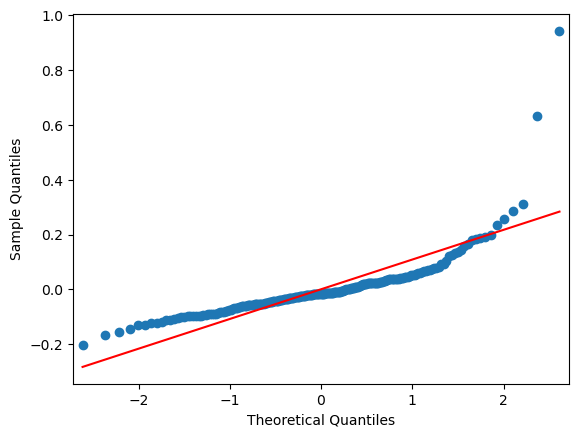

In [5]:
sm.qqplot(ols_fit.resid, line='s');

#### Hsitogram

Histogramme des observations par rapport aux prévisions. Résultats limités à > 0

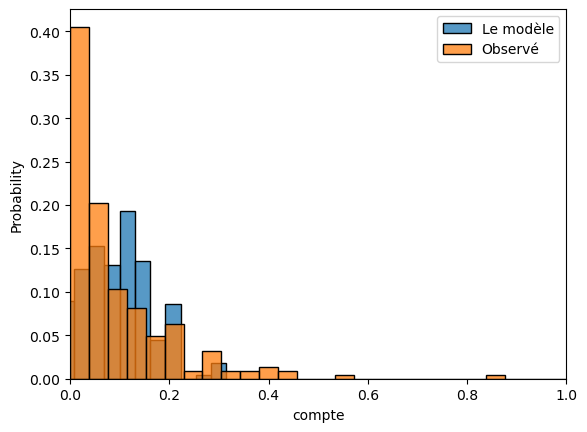

In [6]:
Y_max = Y.max()
Y_min = Y.min()

ax = sns.histplot(ols_fit.fittedvalues, label="Le modèle", stat="probability")
ax = sns.histplot(Y, label="Observé", stat="probability")

ax.set(xlim=(0, 1))
ax.legend()
plt.show()

#### Sans la variable d'orientation

In [7]:
# make dumby variables
x_dum = pd.get_dummies(w_d[x_cols[1:]], drop_first=True)
Y = w_d["compte"]

an_ols = sm.OLS(Y, x_dum)
ols_fit = an_ols.fit()
ols_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 compte   R-squared (uncentered):                   0.483
Model:                            OLS   Adj. R-squared (uncentered):              0.459
Method:                 Least Squares   F-statistic:                              19.80
Date:                Wed, 11 Oct 2023   Prob (F-statistic):                    1.40e-25
Time:                        08:00:09   Log-Likelihood:                          162.25
No. Observations:                 222   AIC:                                     -304.5
Df Residuals:                     212   BIC:                                     -270.5
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
substrat_gravier             0.0302      0.026      1.160      0.247      -0.021       0.081
substrat_sable fin           0.0893      0.021      4.282      0.000       0.048       0.130
substrat_sable grosssier     0.0402      0.031      1.304      0.194      -0.021       0.101
frequentation_moyenne        0.1494      0.023      6.556      0.000       0.105       0.194
frequentation_élévée         0.0907      0.023      3.963      0.000       0.046       0.136
situation_urbain            -0.0335      0.020     -1.708      0.089      -0.072       0.005
distance_500 - 1000m         0.0511      0.069      0.742      0.459      -0.085       0.187
distance_< 100m             -0.0008      0.017     -0.046      0.964      -0.035       0.033
distance_> 1000m             0.0063      0.034      0.188      0.851      -0.060       0.072
objet_fragment              -0.0861      0.016     -5.422      0.000      -0.117      -0.055
==============================================================================
Omnibus:                      225.668   Durbin-Watson:                   1.684
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6792.683
Skew:                           4.003   Prob(JB):                         0.00
Kurtosis:                      28.889   Cond. No.                         11.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### QQ plot

Un graphique q-q est un graphique des quantiles du premier ensemble de données par rapport aux quantiles du second ensemble de données. Par quantile, nous entendons la fraction (ou le pourcentage) de points inférieurs à la valeur donnée. Ainsi, le quantile 0,3 (ou 30 %) est le point auquel 30 % des données sont inférieures et 70 % supérieures à cette valeur.

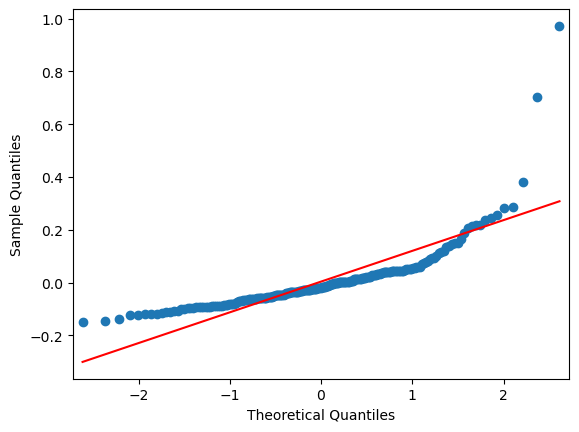

In [8]:
sm.qqplot(ols_fit.resid, line='s');

#### Sans la variable de distance

In [9]:
x_cols = ["orientation", "substrat", "situation", "objet"]

# make dumby variables
x_dum = pd.get_dummies(w_d[x_cols], drop_first=True)
Y = w_d["compte"]

an_ols = sm.OLS(Y, x_dum)
ols_fit = an_ols.fit()
ols_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 compte   R-squared (uncentered):                   0.534
Model:                            OLS   Adj. R-squared (uncentered):              0.488
Method:                 Least Squares   F-statistic:                              11.58
Date:                Wed, 11 Oct 2023   Prob (F-statistic):                    5.58e-24
Time:                        08:00:09   Log-Likelihood:                          173.81
No. Observations:                 222   AIC:                                     -307.6
Df Residuals:                     202   BIC:                                     -239.6
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
orientation_ENE              0.2251      0.067      3.379      0.001       0.094       0.356
orientation_ESE              0.0943      0.059      1.600      0.111      -0.022       0.211
orientation_N                0.1445      0.035      4.144      0.000       0.076       0.213
orientation_NE               0.0923      0.030      3.048      0.003       0.033       0.152
orientation_NNE              0.1400      0.042      3.306      0.001       0.056       0.223
orientation_NNO              0.1425      0.032      4.462      0.000       0.080       0.206
orientation_NO               0.2101      0.030      7.009      0.000       0.151       0.269
orientation_O                0.0855      0.045      1.891      0.060      -0.004       0.175
orientation_ONO              0.0703      0.050      1.395      0.165      -0.029       0.170
orientation_OSO              0.1099      0.033      3.295      0.001       0.044       0.176
orientation_S                0.1265      0.041      3.079      0.002       0.045       0.208
orientation_SE               0.1518      0.042      3.597      0.000       0.069       0.235
orientation_SO               0.1650      0.031      5.374      0.000       0.104       0.226
orientation_SSE              0.1091      0.037      2.916      0.004       0.035       0.183
orientation_SSO              0.1332      0.038      3.491      0.001       0.058       0.208
substrat_gravier             0.0335      0.034      0.975      0.331      -0.034       0.101
substrat_sable fin           0.0601      0.023      2.561      0.011       0.014       0.106
substrat_sable grosssier    -0.0673      0.032     -2.094      0.038      -0.131      -0.004
situation_urbain            -0.0511      0.023     -2.179      0.031      -0.097      -0.005
objet_fragment              -0.0911      0.016     -5.877      0.000      -0.122      -0.061
==============================================================================
Omnibus:                      229.242   Durbin-Watson:                   1.671
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7485.724
Skew:                           4.068   Prob(JB):                         0.00
Kurtosis:                      30.259   Cond. No.                         10.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### QQ plot

Un graphique q-q est un graphique des quantiles du premier ensemble de données par rapport aux quantiles du second ensemble de données. Par quantile, nous entendons la fraction (ou le pourcentage) de points inférieurs à la valeur donnée. Ainsi, le quantile 0,3 (ou 30 %) est le point auquel 30 % des données sont inférieures et 70 % supérieures à cette valeur.

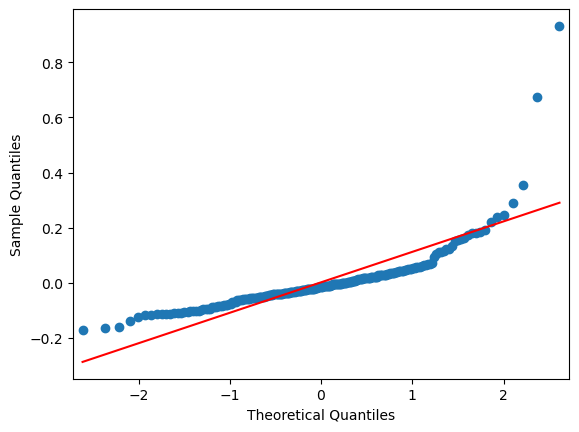

In [10]:
sm.qqplot(ols_fit.resid, line='s');

## Plage seche

In [11]:
# separate the first zone
wdi = wdx[wdx.position == "plage-seche"].copy()
# wdx["const"] = 1
scaled = (wdi["compte"] - wdi["compte"].min()) / (wdi["compte"].max() - wdi["compte"].min())
wdi["compte"] = scaled

# combine the fragments
w_f = wdi[wdi.objet.isin(["souple", "fdure"])].copy()
souple_d = w_f.groupby(["echantillon", *x_cols[:-1]], as_index=False).compte.sum()
souple_d["objet"] = "fragment"

# isolate the fibres
fibres = wdi[wdi.objet.isin(["fibres"])].copy()

# combine the aggregate fragments and the fibres
w_d = pd.concat([souple_d[[*x_cols, *y_col]], fibres[[*x_cols, *y_col]]])

w_d.head().style.set_table_styles(table_css_styles).set_caption(caption)

,orientation,substrat,situation,objet,compte
0,NNE,galet,campagne,fragment,0.023911
1,NE,galet,campagne,fragment,0.005013
2,NE,galet,campagne,fragment,0.008099
3,NE,galet,campagne,fragment,0.004242
4,NNE,galet,campagne,fragment,0.001928


### Régression des moindres carrés ordinaires (MCO)

__Toutes les variables__

In [12]:
# make dumby variables
x_dum = pd.get_dummies(w_d[x_cols], drop_first=True)
Y = w_d["compte"]

an_ols = sm.OLS(Y, x_dum)
ols_fit = an_ols.fit()
ols_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 compte   R-squared (uncentered):                   0.506
Model:                            OLS   Adj. R-squared (uncentered):              0.460
Method:                 Least Squares   F-statistic:                              11.02
Date:                Wed, 11 Oct 2023   Prob (F-statistic):                    2.77e-21
Time:                        08:00:10   Log-Likelihood:                          266.27
No. Observations:                 212   AIC:                                     -496.5
Df Residuals:                     194   BIC:                                     -436.1
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
orientation_N                0.1108      0.025      4.361      0.000       0.061       0.161
orientation_NE               0.0873      0.020      4.341      0.000       0.048       0.127
orientation_NNE              0.0725      0.025      2.933      0.004       0.024       0.121
orientation_NNO              0.0604      0.030      2.027      0.044       0.002       0.119
orientation_NO               0.1267      0.034      3.730      0.000       0.060       0.194
orientation_O                0.1256      0.036      3.482      0.001       0.054       0.197
orientation_ONO              0.0781      0.033      2.386      0.018       0.014       0.143
orientation_OSO             -0.0066      0.026     -0.256      0.798      -0.057       0.044
orientation_S                0.1446      0.026      5.531      0.000       0.093       0.196
orientation_SE               0.1580      0.049      3.207      0.002       0.061       0.255
orientation_SO               0.0877      0.023      3.876      0.000       0.043       0.132
orientation_SSE              0.0942      0.032      2.919      0.004       0.031       0.158
orientation_SSO              0.1211      0.033      3.704      0.000       0.057       0.186
substrat_gravier             0.1316      0.024      5.460      0.000       0.084       0.179
substrat_sable fin          -0.0294      0.020     -1.438      0.152      -0.070       0.011
substrat_sable grosssier    -0.0503      0.034     -1.489      0.138      -0.117       0.016
situation_urbain            -0.0227      0.016     -1.384      0.168      -0.055       0.010
objet_fragment              -0.0542      0.010     -5.493      0.000      -0.074      -0.035
==============================================================================
Omnibus:                      281.847   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29373.235
Skew:                           5.557   Prob(JB):                         0.00
Kurtosis:                      59.584   Cond. No.                         16.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

__Residuals__

Dans la régression linéaire, un _residual_ est la différence entre la valeur réelle et la valeur prédite par le modèle (y-ŷ) pour un point donné. Un modèle de régression des moindres carrés minimise la somme des carrés des résidus

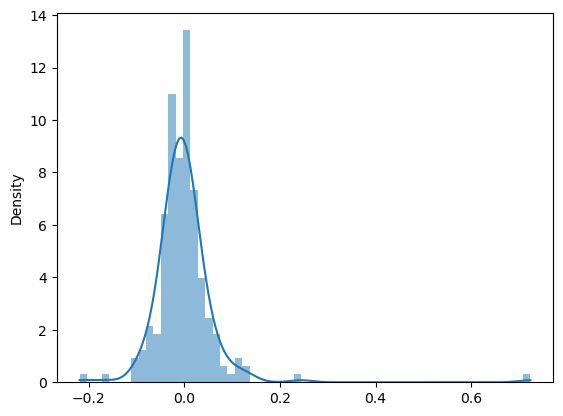

In [13]:
fig, ax = plt.subplots()
sns.histplot(x=ols_fit.resid, ax=ax, stat="density", linewidth=0, kde=True)
plt.show()

#### QQ plot

Un graphique q-q est un graphique des quantiles du premier ensemble de données par rapport aux quantiles du second ensemble de données. Par quantile, nous entendons la fraction (ou le pourcentage) de points inférieurs à la valeur donnée. Ainsi, le quantile 0,3 (ou 30 %) est le point auquel 30 % des données sont inférieures et 70 % supérieures à cette valeur.

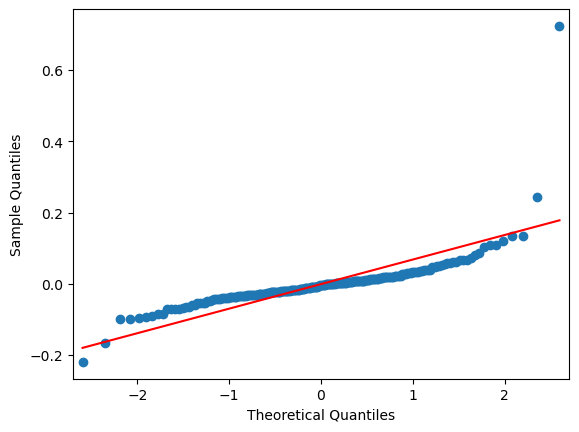

In [14]:
sm.qqplot(ols_fit.resid, line='s');

#### Histogram

Histogramme des observations par rapport aux prévisions. Résultats limités à > 0

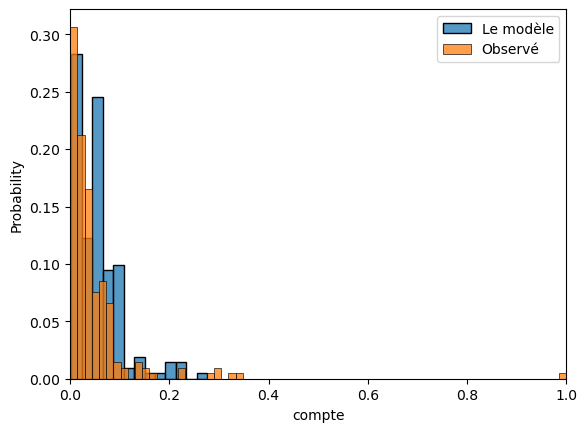

In [15]:
Y_max = Y.max()
Y_min = Y.min()

ax = sns.histplot(ols_fit.fittedvalues, label="Le modèle", stat="probability")
ax = sns.histplot(Y, label="Observé", stat="probability")
# ax.set(ylim=(Y_min, Y_max+10))
ax.set(xlim=(0, 1))
ax.legend()
plt.show()

#### Sans la variable d'orientation

In [16]:
# make dumby variables
x_dum = pd.get_dummies(w_d[x_cols[1:]], drop_first=True)
Y = w_d["compte"]

an_ols = sm.OLS(Y, x_dum)
ols_fit = an_ols.fit()
ols_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 compte   R-squared (uncentered):                   0.370
Model:                            OLS   Adj. R-squared (uncentered):              0.354
Method:                 Least Squares   F-statistic:                              24.27
Date:                Wed, 11 Oct 2023   Prob (F-statistic):                    3.41e-19
Time:                        08:00:11   Log-Likelihood:                          240.52
No. Observations:                 212   AIC:                                     -471.0
Df Residuals:                     207   BIC:                                     -454.3
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
substrat_gravier             0.1634      0.019      8.742      0.000       0.127       0.200
substrat_sable fin           0.0590      0.010      6.104      0.000       0.040       0.078
substrat_sable grosssier     0.0665      0.016      4.217      0.000       0.035       0.098
situation_urbain            -0.0129      0.012     -1.066      0.288      -0.037       0.011
objet_fragment              -0.0384      0.010     -3.774      0.000      -0.058      -0.018
==============================================================================
Omnibus:                      296.299   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33925.103
Skew:                           6.066   Prob(JB):                         0.00
Kurtosis:                      63.773   Cond. No.                         3.97
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### QQ plot

Un graphique q-q est un graphique des quantiles du premier ensemble de données par rapport aux quantiles du second ensemble de données. Par quantile, nous entendons la fraction (ou le pourcentage) de points inférieurs à la valeur donnée. Ainsi, le quantile 0,3 (ou 30 %) est le point auquel 30 % des données sont inférieures et 70 % supérieures à cette valeur.

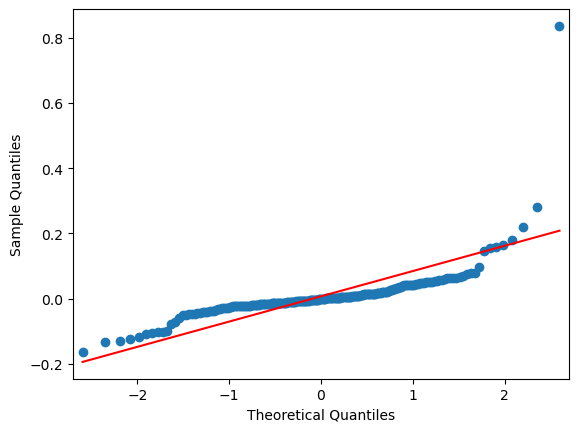

In [17]:
sm.qqplot(ols_fit.resid, line='s');

#### Sans la variable de distance

In [18]:
x_cols = ["orientation", "substrat", "situation", "objet"]

# make dumby variables
x_dum = pd.get_dummies(w_d[x_cols], drop_first=True)
Y = w_d["compte"]

an_ols = sm.OLS(Y, x_dum)
ols_fit = an_ols.fit()
ols_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 compte   R-squared (uncentered):                   0.506
Model:                            OLS   Adj. R-squared (uncentered):              0.460
Method:                 Least Squares   F-statistic:                              11.02
Date:                Wed, 11 Oct 2023   Prob (F-statistic):                    2.77e-21
Time:                        08:00:11   Log-Likelihood:                          266.27
No. Observations:                 212   AIC:                                     -496.5
Df Residuals:                     194   BIC:                                     -436.1
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
orientation_N                0.1108      0.025      4.361      0.000       0.061       0.161
orientation_NE               0.0873      0.020      4.341      0.000       0.048       0.127
orientation_NNE              0.0725      0.025      2.933      0.004       0.024       0.121
orientation_NNO              0.0604      0.030      2.027      0.044       0.002       0.119
orientation_NO               0.1267      0.034      3.730      0.000       0.060       0.194
orientation_O                0.1256      0.036      3.482      0.001       0.054       0.197
orientation_ONO              0.0781      0.033      2.386      0.018       0.014       0.143
orientation_OSO             -0.0066      0.026     -0.256      0.798      -0.057       0.044
orientation_S                0.1446      0.026      5.531      0.000       0.093       0.196
orientation_SE               0.1580      0.049      3.207      0.002       0.061       0.255
orientation_SO               0.0877      0.023      3.876      0.000       0.043       0.132
orientation_SSE              0.0942      0.032      2.919      0.004       0.031       0.158
orientation_SSO              0.1211      0.033      3.704      0.000       0.057       0.186
substrat_gravier             0.1316      0.024      5.460      0.000       0.084       0.179
substrat_sable fin          -0.0294      0.020     -1.438      0.152      -0.070       0.011
substrat_sable grosssier    -0.0503      0.034     -1.489      0.138      -0.117       0.016
situation_urbain            -0.0227      0.016     -1.384      0.168      -0.055       0.010
objet_fragment              -0.0542      0.010     -5.493      0.000      -0.074      -0.035
==============================================================================
Omnibus:                      281.847   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29373.235
Skew:                           5.557   Prob(JB):                         0.00
Kurtosis:                      59.584   Cond. No.                         16.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### QQ plot

Un graphique q-q est un graphique des quantiles du premier ensemble de données par rapport aux quantiles du second ensemble de données. Par quantile, nous entendons la fraction (ou le pourcentage) de points inférieurs à la valeur donnée. Ainsi, le quantile 0,3 (ou 30 %) est le point auquel 30 % des données sont inférieures et 70 % supérieures à cette valeur.

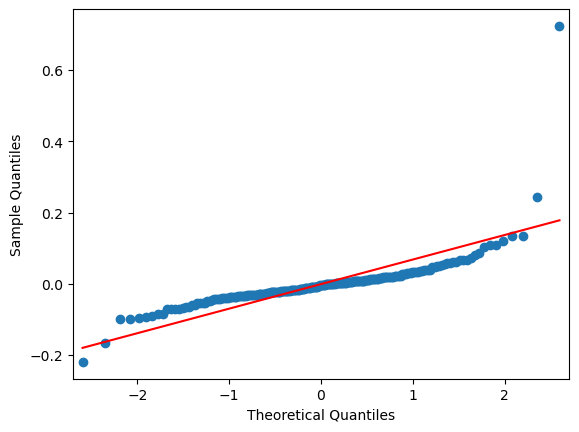

In [19]:
sm.qqplot(ols_fit.resid, line='s');

In [20]:
%watermark --iversions -b -r

Git repo: https://github.com/hammerdirt-analyst/plastock.git

Git branch: glm_p

numpy      : 1.24.2
matplotlib : 3.7.1
seaborn    : 0.12.2
pandas     : 2.0.0
statsmodels: 0.13.5
scipy      : 1.10.1



In [21]:
# from sklearn.compose import make_column_selector as selector
# numerical_columns_selector = selector(dtype_exclude=object)
# categorical_columns_selector = selector(dtype_include=object)

# regressors = ["orientation", "substrat", "frequentation", "situatation", "distance", "objet"] 

# numerical_columns = numerical_columns_selector(data)
# categorical_columns = categorical_columns_selector(data)